## 0. 목표

오토 인코더를 활용하여 손상된 문서에서 노이즈를 제거하여 원본 문서를 복원하는 인공지능을 제작한다.

오토 인코더는 눈으로 평가해야 한다!

In [248]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

try:
    plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
except:
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        plt.rcParams['font.family'] = 'AppleGothic'

plt.rcParams['axes.unicode_minus'] = False
fm._load_fontmanager(try_read_cache=False)

## 1. 데이터 확인

### 데이터 구성 확인

In [249]:
import torch
import glob

NOISED_PATHS = sorted(glob.glob("./train/train/*.png"))
CLEANED_PATHS = sorted(glob.glob("./train/train_cleaned/*.png"))
TEST_PATHS = sorted(glob.glob("./test/*.png"))

SAMPLE_NOISED_PATH = "./train/train/2.png"
SAMPLE_CLEANED_PATH = "./train/train_cleaned/2.png"

print("[파일 개수]")
print(f"· train: {len(NOISED_PATHS)}개")
print(f"· train_cleaned: {len(CLEANED_PATHS)}개")
print(f"· test: {len(TEST_PATHS)}개")

[파일 개수]
· train: 144개
· train_cleaned: 144개
· test: 72개


학습 데이터가 144개로 적은 편이다.

### 데이터 오류치 확인

In [250]:
import os

set_noised = set(os.listdir("./train/train"))
set_cleaned = set(os.listdir("./train/train_cleaned"))
set_test = set(os.listdir("./test"))

# 매칭되지 않는 데이터 확인
print(f"· train 폴더에만 있는 파일: {len(set_noised - set_cleaned)}개")
print(f"· train_cleaned 폴더에만 있는 파일: {len(set_cleaned - set_noised)}개")

# 학습 데이터와 겹치는 테스트 데이터 확인
print(f"· 학습-테스트 겹치는 파일: {len(set_noised & set_test)}개")

· train 폴더에만 있는 파일: 0개
· train_cleaned 폴더에만 있는 파일: 0개
· 학습-테스트 겹치는 파일: 0개


기초적인 데이터 오류는 없다.

### 샘플 데이터 확인

In [251]:
# 데이터 확인
import torchvision

sample = torchvision.io.read_image(SAMPLE_NOISED_PATH)
print(f"· 클래스: {type(sample)}\n· 데이터 타입: {sample.dtype}\n· 사이즈: {sample.shape}")

· 클래스: <class 'torch.Tensor'>
· 데이터 타입: torch.uint8
· 사이즈: torch.Size([1, 258, 540])


- uint8 형식으로, 0부터 255까지의 값을 순환하는 구조이다.

- 사이즈는 C, H, W 형태이다.

- 텐서 타입이다.

In [252]:
# 샘플 이미지 랜덤 출력
import random

rand_idx = random.randint(0, len(NOISED_PATHS))
rand_train = NOISED_PATHS[rand_idx]
rand_train_cleaned = CLEANED_PATHS[rand_idx]

rand_train = torchvision.io.read_image(rand_train)[0]
rand_train_cleaned = torchvision.io.read_image(rand_train_cleaned)[0]

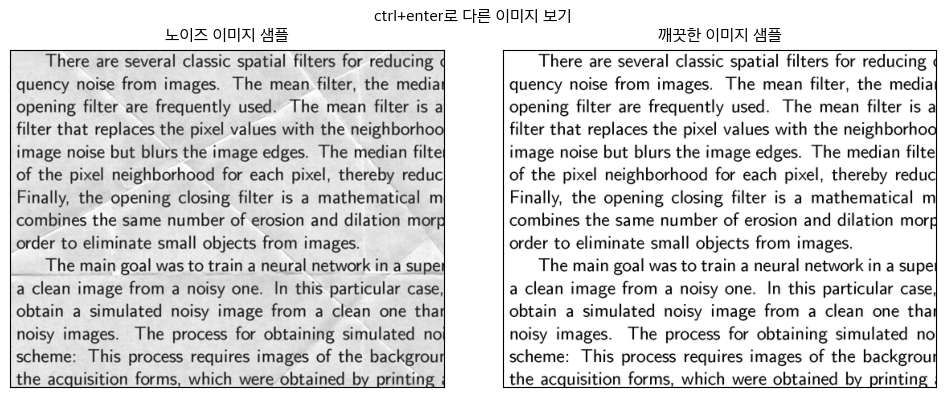

In [253]:
def remove_ticks(columns=2):
    for num in range(columns):
        axes[num].set_xticks([])
        axes[num].set_yticks([])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
remove_ticks()

axes[0].imshow(rand_train, cmap="gray")
axes[1].imshow(rand_train_cleaned, cmap="gray")

fig.suptitle("ctrl+enter로 다른 이미지 보기")
axes[0].set_title("노이즈 이미지 샘플")
axes[1].set_title("깨끗한 이미지 샘플")

plt.tight_layout()
plt.show()

깨끗한 이미지 위에 전체적으로 노이즈를 덧씌운 형태이다.

즉, 현 데이터셋에서 노이즈를 입힌다는 것은 밝기값을 낮춘다는 것이다.

그림마다 크기가 차이가 나는 것이 확인되므로, 구성 점검이 필요하다.

### 사이즈 구성 확인

In [254]:
# 학습 이미지 사이즈 구성 파악
size_list = []

for idx in range(len(NOISED_PATHS)):
    file = NOISED_PATHS[idx]
    file = torchvision.io.read_image(file)
    size_list.append(file.shape)

print("[학습 데이터 사이즈 구성]")
for size in set(size_list):
    print(f"· (H{size[1]}, W{size[2]}): {size_list.count(size)}개") 

[학습 데이터 사이즈 구성]
· (H258, W540): 48개
· (H420, W540): 96개


In [255]:
# 테스트 이미지 사이즈 구성 파악
size_list = []

for idx in range(len(TEST_PATHS)):
    file = TEST_PATHS[idx]
    file = torchvision.io.read_image(file)
    size_list.append(file.shape)

print("[테스트 데이터 사이즈 구성]")
for size in set(size_list):
    print(f"· (H{size[1]}, W{size[2]}): {size_list.count(size)}개") 

[테스트 데이터 사이즈 구성]
· (H258, W540): 24개
· (H420, W540): 48개


사이즈는 두 종류로, 세로 사이즈가 258과 420으로 나뉜다.

전처리 과정에서 사이즈를 통일해야 한다.

### 오류치 확인 1. 노이즈 이미지가 깨끗한 이미지보다 밝은 경우

In [256]:
sample_noised = torchvision.io.read_image(SAMPLE_NOISED_PATH)[0]
sample_cleaned = torchvision.io.read_image(SAMPLE_CLEANED_PATH)[0]

# 노이즈 이미지 중 깨끗한 이미지보다 밝은 픽셀 확인
err_bright = (sample_noised > sample_cleaned)
print(f"깨끗한 이미지보다 밝은 노이즈 이미지 픽셀 개수: {err_bright.sum().item()}개")

깨끗한 이미지보다 밝은 노이즈 이미지 픽셀 개수: 11930개


육안으로 봤을 때는 노이즈 이미지가 전체적으로 어두울 것으로 짐작되었으므로, 

오류치 여부를 확인하기 위해 실제 이미지를 출력해본다.

· 좌표: (88,32)
· 노이즈 이미지 픽셀 값: 127
· 깨끗한 이미지 픽셀 값: 101


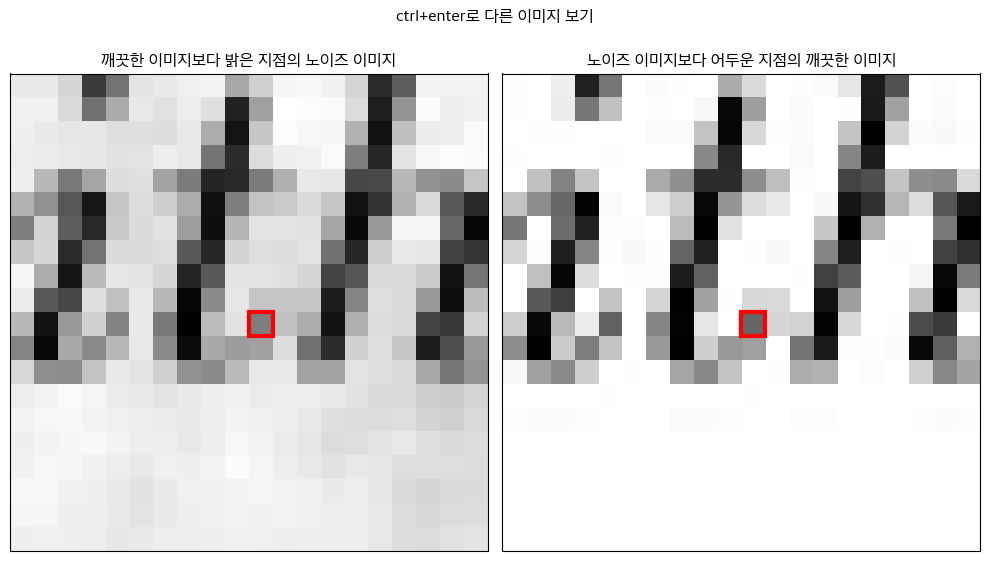

In [257]:
# 실제 확인
err_pixel_list = torch.nonzero(err_bright)

rand_idx = random.randint(0, len(err_pixel_list))

x, y = err_pixel_list[rand_idx][0], err_pixel_list[rand_idx][1]

print(f"· 좌표: ({x},{y})")
print(f"· 노이즈 이미지 픽셀 값: {sample_noised[x,y]}")
print(f"· 깨끗한 이미지 픽셀 값: {sample_cleaned[x,y]}")


# 20x20 부분 확대
import matplotlib.patches as patches

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
remove_ticks()

axes[0].imshow(sample_noised[x-10:x+10, y-10:y+10], cmap="gray")
axes[1].imshow(sample_cleaned[x-10:x+10, y-10:y+10], cmap="gray")

fig.suptitle("ctrl+enter로 다른 이미지 보기")
axes[0].set_title("깨끗한 이미지보다 밝은 지점의 노이즈 이미지")
axes[1].set_title("노이즈 이미지보다 어두운 지점의 깨끗한 이미지")

axes[0].add_patch(patches.Rectangle((9.5, 9.5), 1, 1, edgecolor='red', fill=False, linewidth=3))
axes[1].add_patch(patches.Rectangle((9.5, 9.5), 1, 1, edgecolor='red', fill=False, linewidth=3))

plt.tight_layout()
plt.show()

전반적으로 노이즈 이미지가 깨끗한 이미지보다 더 밝은 현상은 주로 글자에서 발생하는 것을 알 수 있다.

In [258]:
# 전체적인 밝기값 비교
print("[밝기값 최소·최대]")
print(f"· 노이즈 이미지: {sample_noised.min()}, {sample_noised.max()}")
print(f"· 깨끗한 이미지: {sample_cleaned.min()}, {sample_cleaned.max()}")

print("\n[전체 픽셀값 평균]")
print(f"· 노이즈 이미지: {sample_noised.sum().item()/139320:.4f}")
print(f"· 깨끗한 이미지: {sample_cleaned.sum().item()/139320:.4f}")

print("\n[특이 픽셀값 평균]")
print(f"· 노이즈 이미지: {sample_noised[err_bright].sum().item()/139320:.4f}")
print(f"· 깨끗한 이미지: {sample_cleaned[err_bright].sum().item()/139320:.4f}")

[밝기값 최소·최대]
· 노이즈 이미지: 0, 246
· 깨끗한 이미지: 0, 255

[전체 픽셀값 평균]
· 노이즈 이미지: 195.4372
· 깨끗한 이미지: 228.6158

[특이 픽셀값 평균]
· 노이즈 이미지: 6.5748
· 깨끗한 이미지: 4.9834


깨끗한 이미지에 비해 노이즈 이미지가 전체적으로 약 -30만큼 어두우나,

노이즈 이미지가 더 밝은 부분은 평균적으로 약 1.5의 밝기값 차이를 보인다.

특이 픽셀값의 평균도 어두운 색, 즉 글자 중심이라는 것을 알 수 있다.

이는 글자 위에도 회색 노이즈를 덧입히며 오히려 밝아지는 현상으로 보인다.

### 오류치 확인 2. 노이즈값이 255인 경우

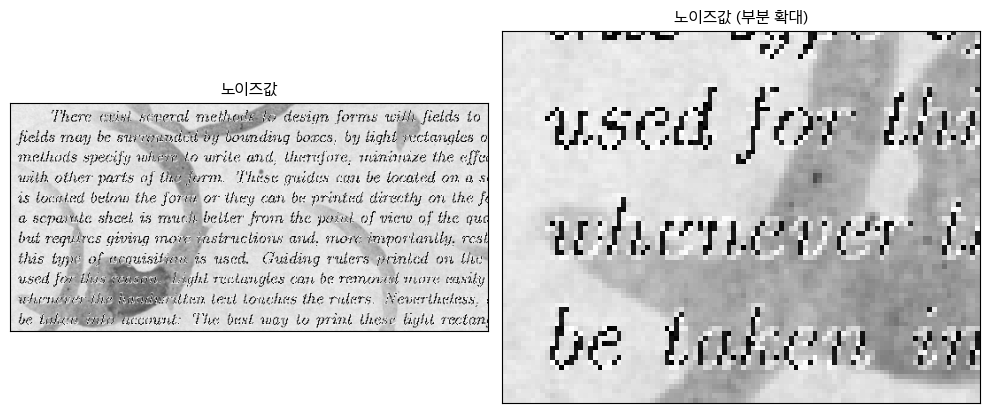

In [259]:
# 두 이미지 픽셀값의 차이(노이즈값) 시각화
noise = sample_noised - sample_cleaned
noise_zoomed = noise[180:, :100]


fig, axes = plt.subplots(1, 2, figsize=(10, 8))
remove_ticks()

axes[0].imshow(noise, cmap="gray")
axes[1].imshow(noise_zoomed, cmap="gray")

axes[0].set_title("노이즈값")
axes[1].set_title("노이즈값 (부분 확대)")

plt.tight_layout()
plt.show()

위의 결론에서는 글자 위에도 회색 노이즈를 덧입히는 과정에서 글자가 일정 수준 밝아질 수 있음을 도출했다.

그러나 노이즈 값 시각화 결과, 글자 중심으로 일관적이지 않은 노이즈값이 발생하고 있음을 알 수 있다.

In [260]:
# 흰색 노이즈값 조사
err_white = (noise == 255)
err_pixel_list = torch.nonzero(err_white)

print(f"값이 255인 노이즈값 개수: {err_white.sum().item()}개")

값이 255인 노이즈값 개수: 406개


· 좌표: (39,465)
· 노이즈 이미지 픽셀 값: 149
· 깨끗한 이미지 픽셀 값: 150


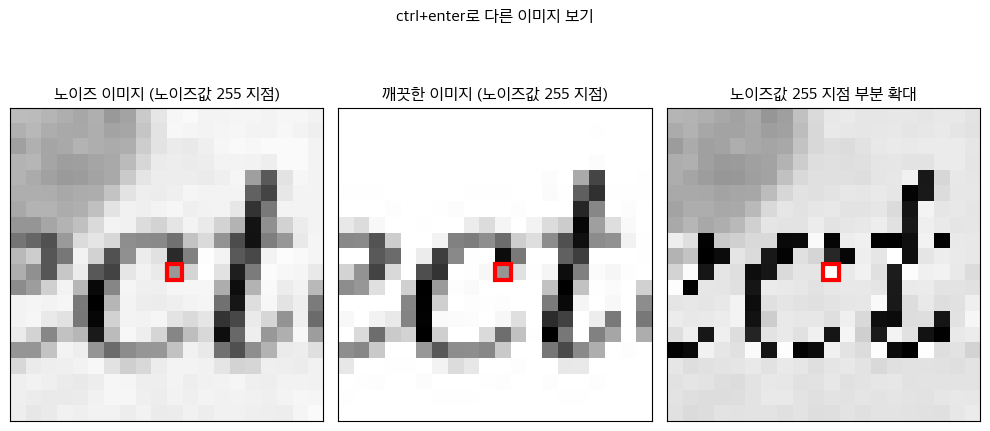

In [261]:
# 실제 확인
rand_idx = random.randint(0, len(err_pixel_list))

pix_x = err_pixel_list[rand_idx][0]
pix_y = err_pixel_list[rand_idx][1]


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
remove_ticks(3)

axes[0].imshow(sample_noised[pix_x-10:pix_x+10, pix_y-10:pix_y+10], cmap="gray")
axes[1].imshow(sample_cleaned[pix_x-10:pix_x+10, pix_y-10:pix_y+10], cmap="gray")
axes[2].imshow(noise[pix_x-10:pix_x+10, pix_y-10:pix_y+10], cmap="gray")

fig.suptitle("ctrl+enter로 다른 이미지 보기")
axes[0].set_title("노이즈 이미지 (노이즈값 255 지점)")
axes[1].set_title("깨끗한 이미지 (노이즈값 255 지점)")
axes[2].set_title("노이즈값 255 지점 부분 확대")

axes[0].add_patch(patches.Rectangle((9.5, 9.5), 1, 1, edgecolor='red', fill=False, linewidth=3))
axes[1].add_patch(patches.Rectangle((9.5, 9.5), 1, 1, edgecolor='red', fill=False, linewidth=3))
axes[2].add_patch(patches.Rectangle((9.5, 9.5), 1, 1, edgecolor='red', fill=False, linewidth=3))


print(f"· 좌표: ({pix_x},{pix_y})")
print(f"· 노이즈 이미지 픽셀 값: {sample_noised[pix_x, pix_y]}")
print(f"· 깨끗한 이미지 픽셀 값: {sample_cleaned[pix_x, pix_y]}")

plt.tight_layout()
plt.show()


255라는 노이즈값은 노이즈 이미지의 값이 깨끗한 이미지 값보다 1 작을 때 발생한다.

즉, 노이즈의 값이 -1인 상황이므로 오류라고 보기는 어렵다.

이는 0부터 255까지의 숫자를 순환하는 uint8 형식에서 기인한 것으로 보인다.

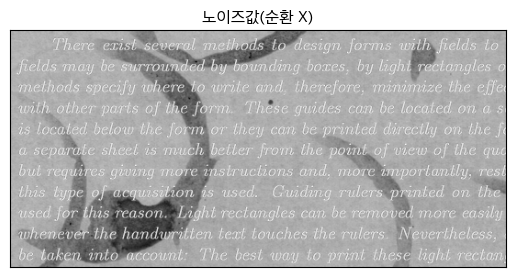

In [262]:
# 순환되지 않도록 실수형으로 계산 후 정규화
noise_float = sample_noised.float() - sample_cleaned.float() 
noise_norm = ((noise_float - noise_float.min()) / (noise_float.max() - noise_float.min())) * 255

plt.imshow(noise_norm, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.title("노이즈값(순환 X)")
plt.show()

In [263]:
sample_noised_float = sample_cleaned.float() + noise_float
sample_noised_norm = ((sample_noised_float - sample_noised_float.min()) / (sample_noised_float.max() - sample_noised_float.min())) * 255

sample_cleaned_float = sample_noised.float() - noise_float
sample_cleaned_norm = ((sample_cleaned_float - sample_cleaned_float.min()) / (sample_cleaned_float.max() - sample_cleaned_float.min())) * 255


rand_idx = random.randint(0, len(err_pixel_list))

pix_x = err_pixel_list[rand_idx][0]
pix_y = err_pixel_list[rand_idx][1]

print(f"[실수형 노이즈값 랜덤 출력]")
print(f"· 좌표: ({pix_x},{pix_y})")
print(f"· 노이즈 이미지 픽셀 값: {sample_noised_norm[pix_x, pix_y]:.4f}")
print(f"· 깨끗한 이미지 픽셀 값: {sample_cleaned_norm[pix_x, pix_y]:.4f}")
print(f"· 노이즈값: {noise_norm[pix_x, pix_y]}")

[실수형 노이즈값 랜덤 출력]
· 좌표: (113,476)
· 노이즈 이미지 픽셀 값: 149.2683
· 깨끗한 이미지 픽셀 값: 145.0000
· 노이즈값: 201.0


순환하지 않도록 실수형으로 처리하면 보다 자연스러운 결과물이 생성된다.

결론적으로, 검은 글자에 추가적으로 

이를 이용해 데이터를 전처리하면 보다 성능이 우수한 모델이 나올 것이라는 가설을 세울 수 있다.

## 2. 모델 구성

1. 전처리

- 사이즈 구성이 다르므로, 패딩을 추가해야 한다.

- 순환 구조로 인한 문제를 방지하기 위해 실수형으로 전처리한다.

2. 모델 설계

- 패딩 구성 방식에 차이를 두어 실험한다.

    |**패딩**|**예상 학습 소요 시간**|**예상 성능**|
    |---|---|---|
    |0|하|하|
    |평균|중|중상|
    |대칭|장|상|
    |0, 대칭 혼용|최장|최상|

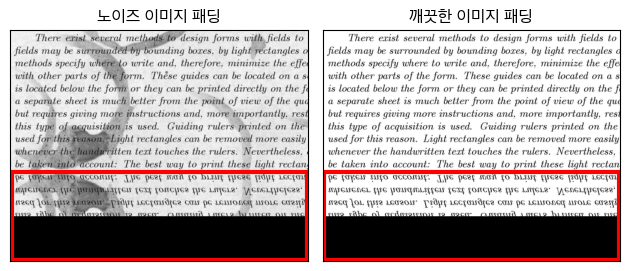

In [264]:
from torch.utils.data import Dataset
from torchvision.transforms import v2

class PaperDataset(Dataset):
    size_set = set([420])

    def __init__(self):
        self.X_files = NOISED_PATHS
        self.y_files = CLEANED_PATHS
        

    def __len__(self):
        return len(self.X_files)
    

    def __getitem__(self, index):
        X = torchvision.io.read_image(NOISED_PATHS[index])
        y = torchvision.io.read_image(CLEANED_PATHS[index])

        # 패딩 사이즈 설정
        X_size = X.shape[1]
        if X_size not in PaperDataset.size_set:
            PaperDataset.size_set.add(X_size)
        max_size = max(PaperDataset.size_set)
        pad = max_size - X_size
        
        transform = v2.Compose([
                v2.Grayscale(num_output_channels=1),
                v2.ToDtype(torch.float32, scale=True),
                # v2.Pad(padding=(0, 0, 0, pad), padding_mode="reflect"),
                v2.Pad(padding=(0, 0, 0, pad//2), padding_mode="reflect"),
                v2.Pad(padding=(0, 0, 0, pad - pad//2), fill=0),
            ])

        return transform(X), transform(y), pad

full_dataset = PaperDataset()

pad_sample_noised, pad_sample_cleaned, _ = full_dataset[72]


fig, axes = plt.subplots(1, 2)
remove_ticks(2)

axes[0].imshow(pad_sample_noised[0], cmap="gray")
axes[1].imshow(pad_sample_cleaned[0], cmap="gray")

axes[0].set_title("노이즈 이미지 패딩")
axes[1].set_title("깨끗한 이미지 패딩")

axes[0].add_patch(patches.Rectangle((3, 258), 535, 159, edgecolor='red', fill=False, linewidth=3))
axes[1].add_patch(patches.Rectangle((3, 258), 535, 159, edgecolor='red', fill=False, linewidth=3))

plt.tight_layout()
plt.show()

In [265]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=0)

noised_imgs, cleaned_imgs, pads = next(iter(train_loader))

In [ ]:
# 오토인코더 정의
import torch.nn as nn
import torch.nn.functional as F

class BaseAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class DenoisingAutoencoder(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # 인코더
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=4),  # 420x540 -> 210x270
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=3),  # 210x270 -> 105x135
#             nn.ReLU(),
#             nn.BatchNorm2d(128),
#             nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=2),  # 105x135 -> 53x68
#             nn.ReLU(),
#             nn.BatchNorm2d(256),
#             nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 53x68 -> 27x34
#             nn.ReLU(),
#             nn.BatchNorm2d(512)
#         )

#         # 디코더
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 27x34 -> 53x68
#             nn.ReLU(),
#             nn.BatchNorm2d(256),
#             nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=2, output_padding=1),  # 53x68 -> 105x135
#             nn.ReLU(),
#             nn.BatchNorm2d(128),
#             nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=3, output_padding=1),   # 105x135 -> 210x270
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=4, output_padding=1),     # 210x270 -> 420x540
#             nn.Sigmoid()  # 픽셀 값 [0, 1]로 정규화
#         )

#     def forward(self, x):
#         # 인코딩
#         encoded = self.encoder(x)

#         # 디코딩
#         decoded = self.decoder(encoded)

#         # 최종 크기 맞춤
#         resized_output = F.interpolate(decoded, size=(420, 540), mode='bilinear', align_corners=False)
#         return resized_output

In [ ]:
import torch.optim as optim


if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


model = BaseAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

model.to(device)

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X, y, _ in train_loader:

        X = X.to(device) # 4D 텐서(배치 포함이니까)
        y = y.to(device) # 4D 텐서(배치 포함이니까)
        
        y_pred = model(X) # 4D 텐서(배치 포함이니까)
        
        loss = criterion(y_pred, y) # 4D 텐서(배치 포함이니까)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/20] - Loss: 0.1279
Epoch [2/20] - Loss: 0.0699
Epoch [3/20] - Loss: 0.0730
Epoch [4/20] - Loss: 0.0538
Epoch [5/20] - Loss: 0.0455
Epoch [6/20] - Loss: 0.0439
Epoch [7/20] - Loss: 0.0446
Epoch [8/20] - Loss: 0.0397
Epoch [9/20] - Loss: 0.0357
Epoch [10/20] - Loss: 0.0353
Epoch [11/20] - Loss: 0.0329
Epoch [12/20] - Loss: 0.0322
Epoch [13/20] - Loss: 0.0318
Epoch [14/20] - Loss: 0.0292
Epoch [15/20] - Loss: 0.0280
Epoch [16/20] - Loss: 0.0274
Epoch [17/20] - Loss: 0.0268
Epoch [18/20] - Loss: 0.0250
Epoch [19/20] - Loss: 0.0240
Epoch [20/20] - Loss: 0.0237


In [270]:
model.eval()
with torch.no_grad():
    for Xs, _, pads in test_loader:
        print(Xs.shape)
        Xs = Xs.to(device)
        y_preds = model(Xs)
        pads = pads
        break

torch.Size([6, 1, 420, 540])


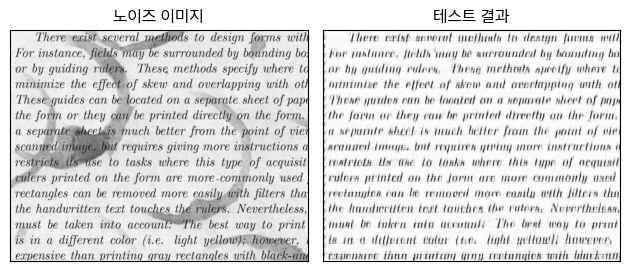

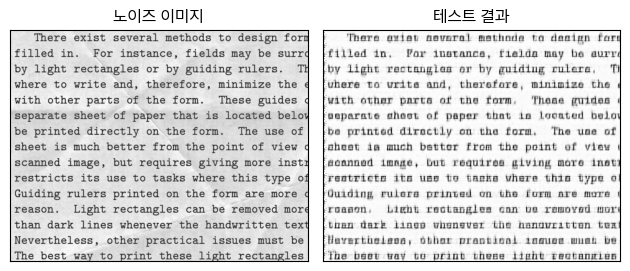

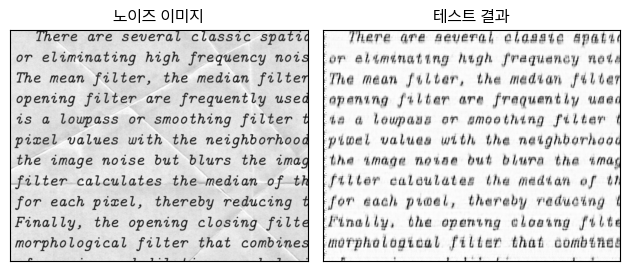

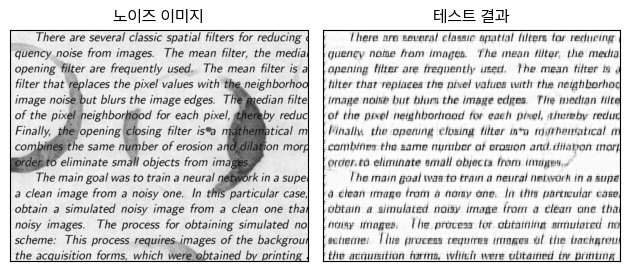

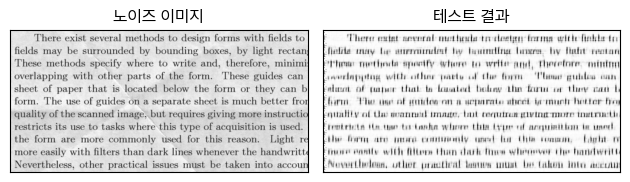

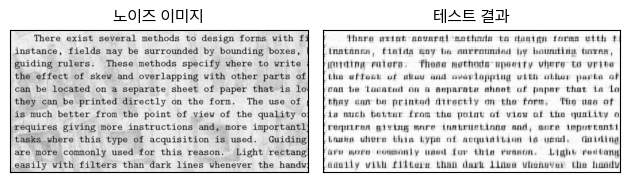

In [271]:
for i in range(Xs.size(0)):
    pad = pads[i].item()

    fig, axes = plt.subplots(1, 2)
    remove_ticks(2)

    axes[0].imshow(Xs[i][0][:-pad if pad > 0 else None, :].cpu(), cmap="gray")
    axes[1].imshow(y_preds[i][0][:-pad if pad > 0 else None, :].cpu(), cmap="gray")

    axes[0].set_title("노이즈 이미지")
    axes[1].set_title("테스트 결과")

    plt.tight_layout()
    plt.show()